In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.distributions as dist
import torch
import copy
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from scripts.utils import ScaleData, train_keys
from scripts.AutoEncoder import Encoder, Decoder, AutoEncoderDataset
from tqdm import tqdm

import itertools
import seaborn as sns
#%matplotlib notebook

In [2]:
device = torch.device("cpu")

In [3]:
def ELBO(encoder, decoder, X):
        # calculate the ELBO loss
        q_z_given_x = encoder.forward(X)

        q_samples = q_z_given_x.rsample()

        ones = torch.ones(3)
        zeros = torch.zeros(3)
        
#         if torch.cuda.is_available():
#             ones.cuda()
#             zeros.cuda()
#             q_samples.cuda()
        
        latent_prior = dist.Normal(zeros, ones)
             
        log_p_z = latent_prior.log_prob(q_samples).sum(-1)

        log_q_z_given_x = q_z_given_x.log_prob(q_samples).sum(-1)

        log_p_x_given_z = decoder.forward(q_samples).log_prob(X).sum(dim=1)
        
        ELBO = log_p_x_given_z + log_p_z - log_q_z_given_x

        return ELBO

In [4]:
encoder = Encoder(3, 15, VAE = True)
decoder = Decoder(3, 15, VAE = True) 

In [5]:
train_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
train_data = AutoEncoderDataset(train_data_path, columns = train_keys, train = True)
train_data.data = train_data.data.sample(10_000)
train_data.scale()

train_loader = DataLoader(train_data, shuffle = True, batch_size = 1048)

valid_data_path = "/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl"
valid_data = AutoEncoderDataset(valid_data_path, columns = train_keys, train = True)
valid_data.data = valid_data.data.sample(10_000)
valid_data.scale()

valid_loader = DataLoader(valid_data, shuffle = True, batch_size = 1048)

In [6]:
# if torch.cuda.is_available():
#     encoder = encoder.cuda()
#     decoder = decoder.cuda() 

opt_vae = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()))
N_epochs = 50 # Note that you may want to run more than 10 epochs!
for epoch in range(N_epochs):
    train_loss = 0.0
    for X in train_loader:
#         if torch.cuda.is_available():
#             X = X.cuda()

        opt_vae.zero_grad()
        loss = -ELBO(encoder, decoder, X).mean()
        loss.backward()
        opt_vae.step()
        train_loss += loss.item() * X.shape[0] / len(train_data)
    print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

Epoch 0, train loss = 22.3873
Epoch 1, train loss = 22.1029
Epoch 2, train loss = 21.9158
Epoch 3, train loss = 21.7448
Epoch 4, train loss = 21.6196
Epoch 5, train loss = 21.5220
Epoch 6, train loss = 21.4831
Epoch 7, train loss = 21.3995
Epoch 8, train loss = 21.3692
Epoch 9, train loss = 21.3785
Epoch 10, train loss = 21.3493
Epoch 11, train loss = 21.2989
Epoch 12, train loss = 21.3131
Epoch 13, train loss = 21.2262
Epoch 14, train loss = 21.2000
Epoch 15, train loss = 21.1556
Epoch 16, train loss = 21.2128
Epoch 17, train loss = 21.1737
Epoch 18, train loss = 21.1125
Epoch 19, train loss = 20.9129
Epoch 20, train loss = 20.7453
Epoch 21, train loss = 20.6381
Epoch 22, train loss = 20.5373
Epoch 23, train loss = 21222.4627
Epoch 24, train loss = 20.6206
Epoch 25, train loss = 20.4540
Epoch 26, train loss = 20.3492
Epoch 27, train loss = 20.0875
Epoch 28, train loss = 20.3307
Epoch 29, train loss = 19.8604
Epoch 30, train loss = 19.9575
Epoch 31, train loss = 19.7103
Epoch 32, train

In [7]:
X_random_batch = next(iter(valid_loader))
X_random_batch.shape

torch.Size([1048, 15])

In [8]:
with torch.no_grad():    
    out = encoder(X_random_batch).sample()

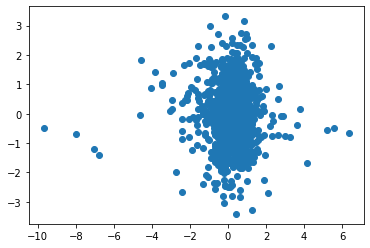

In [9]:
plt.figure()
plt.scatter(out[:,0], out[:,1])

In [10]:
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl"

df_test = pd.read_pickle(test)
df_test = df_test.sample(10_000)
target = df_test['target']
df_test_good = df_test[df_test.target == 1]
df_test_good = df_test_good[train_keys]

df_test_good,_ = ScaleData(df_test_good)

df_test_bad = df_test[df_test.target == 0]
df_test_bad = df_test_bad[train_keys]
df_test_bad,_ = ScaleData(df_test_bad)

df_test_good.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03,6.611000e+03
mean,5.926451e-17,4.871815e-17,1.324456e-16,2.279559e-16,1.074285e-16,1.895742e-16,-1.752241e-16,-1.103506e-16,9.471574e-18,-3.427568e-17,4.543711e-17,-1.005935e-17,1.852205e-16,-9.706684e-17,3.372569e-17
std,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00,1.000076e+00
min,-5.938230e+00,-5.930438e+00,-1.752774e+01,-1.760788e+00,-1.525495e+00,-1.276868e+00,-2.599976e+01,-1.199192e+00,-2.161858e+00,-9.669461e-01,-1.006893e+01,-5.590374e+00,-1.932509e+00,-3.079364e+00,-2.496922e+00
25%,-4.133067e-01,-5.666197e-01,-3.214177e-01,-5.512513e-01,-9.377607e-01,-7.809360e-01,5.561173e-02,-7.371153e-01,-6.431539e-01,-4.695512e-01,-3.512487e-01,-5.468748e-01,-2.679341e-01,-1.167586e-01,-7.108063e-01
50%,-2.114246e-01,-2.660987e-01,-3.214177e-01,-5.512513e-01,-1.333422e-01,-1.598184e-01,5.561173e-02,-2.902423e-01,-4.031625e-01,-3.283336e-01,-1.962716e-01,-2.498064e-01,-2.096651e-01,-1.167586e-01,-1.419290e-01
75%,8.666045e-02,1.916987e-01,2.341182e-02,2.559569e-01,9.523341e-01,5.157280e-01,5.561173e-02,4.555335e-01,2.603264e-01,7.254517e-02,4.758824e-02,2.581700e-01,-8.580669e-02,-1.167586e-01,5.843672e-01
max,1.093440e+01,9.583866e+00,2.933225e+01,5.245085e+00,1.683902e+00,1.546868e+01,9.646827e+00,1.254396e+01,6.726995e+00,1.321705e+01,1.449145e+01,1.095132e+01,1.853756e+01,1.983050e+01,5.496627e+00


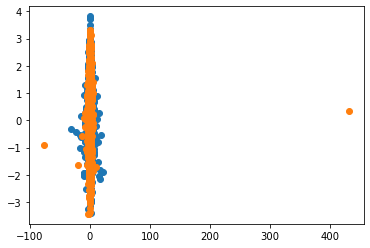

In [11]:
data_good = torch.from_numpy(df_test_good.values).float()
data_bad = torch.from_numpy(df_test_bad.values).float()
#data_good_batch = next(iter(data_good_loader))
with torch.no_grad():
    outputs_good = encoder.forward(data_good).sample()
    outputs_bad = encoder.forward(data_bad).sample()
#    outputs_good = encoder.forward(data_good).sample().detach().numpy()
    
plt.figure()
plt.scatter(outputs_good[:,0], outputs_good[:,1])
plt.scatter(outputs_bad[:,0], outputs_bad[:,1])

In [12]:
AE_output = decoder.forward(encoder.forward(data_good).sample()).sample().detach().numpy()
df_ae_output = pd.DataFrame(AE_output, columns = train_keys)
df_ae_output['AE'] = 'Outputs'

df_test_tmp = df_test_good
df_test_tmp['AE'] = 'Inputs'

In [13]:
df_compare = pd.concat([df_ae_output, df_test_tmp], ignore_index=True)
df_compare_sample = df_compare.sample(10_000)

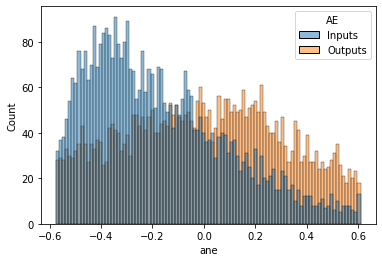

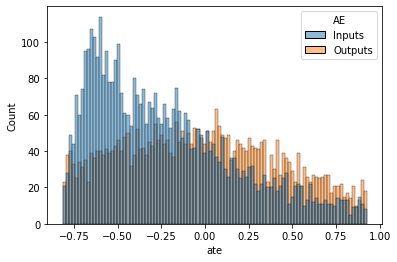

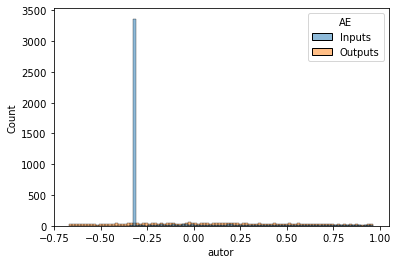

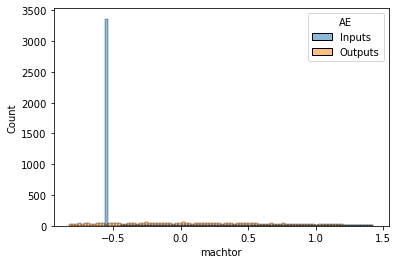

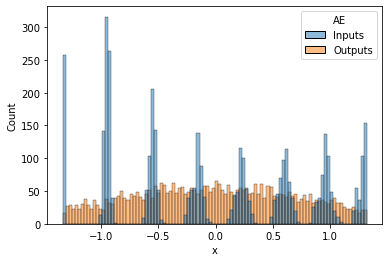

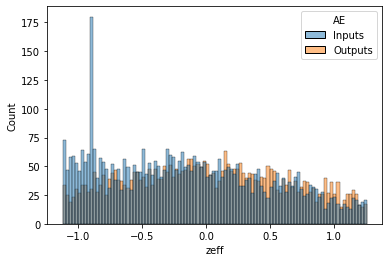

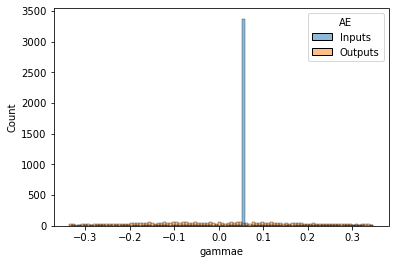

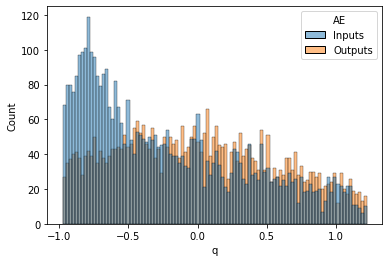

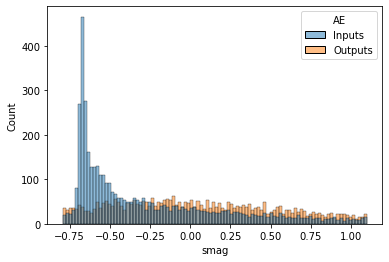

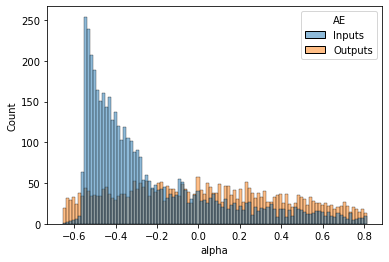

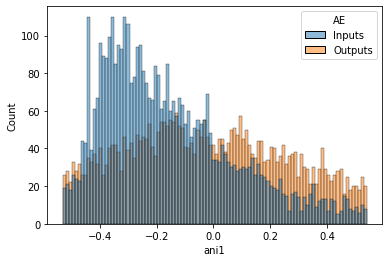

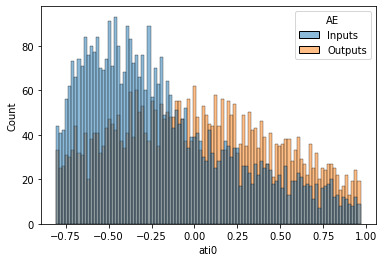

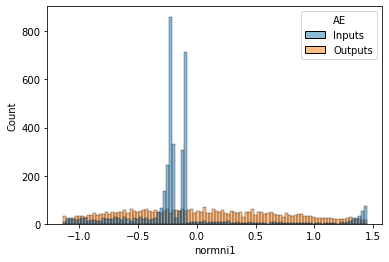

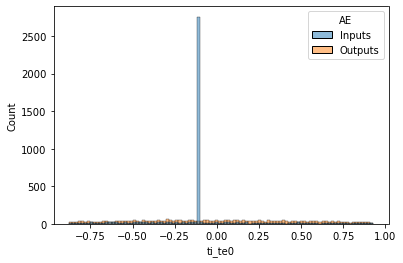

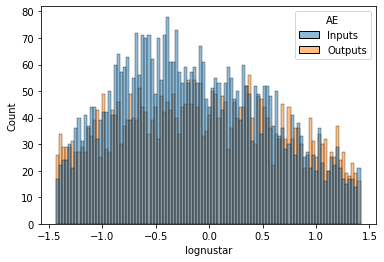

In [14]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample[i].quantile(0.1)
    x_max = df_compare_sample[i].quantile(0.9)
    sns.histplot(data = df_compare_sample, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)

# VAE 2

In [15]:
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        
 
        # encoder
        self.enc1 = nn.Linear(in_features=15, out_features = 10)
        self.enc2 = nn.Linear(in_features=10, out_features = 5)
        
        self.mu = nn.Linear(5, 2)
        self.sigma = nn.Linear(5,2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features = 2, out_features = 5)
        self.dec2 = nn.Linear(in_features = 5, out_features = 10)
        self.dec3 = nn.Linear(10, 15)
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = x.float()
        x = F.relu(self.enc1(x.float()))
        x = F.relu(self.enc2(x.float()))
        # get `mu` and `log_var`
        mu = self.mu(x) # the first feature values as mean
        log_var = self.sigma(x) # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        z = F.relu(self.dec1(z.float()))
        z = F.relu(self.dec2(z.float()))
        reconstruction = self.dec3(z.float())
        return reconstruction.float(), mu.float(), log_var.float()

In [16]:
batch_size = 64
lr = 0.002
epochs = 50

model = LinearVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction = "sum")

In [17]:
def final_loss(MSE_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    MSE = MSE_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [18]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        #data, _ = data
        #data = data.to(device)
        #data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        MSE_loss = criterion(reconstruction.float(), data.float())
        loss = final_loss(MSE_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [19]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(valid_data)/dataloader.batch_size)):
            #data = data.to(device)
            #data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            MSE_loss = criterion(reconstruction.float(), data.float())
            loss = final_loss(MSE_loss, mu, logvar)
            running_loss += loss.item()
        
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [20]:
train_data.data.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,1.491585e-17,-9.011125e-17,-6.322720e-18,7.410961e-16,1.946887e-16,1.670664e-16,-2.290446e-16,2.891465e-16,1.614708e-16,-3.803624e-17,3.525236e-17,-6.237788e-17,2.043476e-16,2.065195e-16,-9.550277e-17
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-8.866637e+01,-1.345323e+01,-3.845394e+01,-1.915758e+00,-1.883034e+00,-1.341976e+00,-1.001079e-02,-1.266400e+00,-1.308644e+01,-1.292064e+01,-1.615913e+01,-3.146190e+01,-1.852788e+00,-3.159887e+00,-2.558047e+00
25%,-9.162338e-02,-5.096025e-01,-2.310656e-01,-5.749417e-01,-7.857326e-01,-8.037494e-01,-1.000073e-02,-7.313616e-01,-6.342963e-01,-4.622333e-01,-1.908906e-01,-4.049799e-01,-2.851373e-01,-1.075780e-01,-7.368321e-01
50%,-4.208859e-02,-2.412843e-01,-2.310656e-01,-5.749417e-01,4.235456e-02,-1.401899e-01,-1.000073e-02,-2.736927e-01,-3.414951e-01,-3.128076e-01,-1.186364e-01,-1.658060e-01,-2.379175e-01,-7.348525e-02,-1.553563e-01
75%,3.278692e-02,1.303181e-01,1.335365e-01,3.478536e-01,8.345674e-01,5.224205e-01,-1.000073e-02,4.381607e-01,2.678040e-01,1.005594e-01,-1.194303e-02,1.462078e-01,2.178400e-02,-7.348525e-02,5.963623e-01
max,9.121828e+00,1.989115e+01,1.376440e+01,5.470903e+00,1.548558e+00,6.569223e+00,9.999500e+01,1.178805e+01,1.151991e+01,2.021524e+01,3.662818e+01,2.919758e+01,2.063586e+01,1.911930e+01,5.811620e+00


In [21]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, valid_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 50


10it [00:01,  6.19it/s]                      
10it [00:01,  6.57it/s]                      


Train Loss: 15.8411
Val Loss: 15.6590
Epoch 2 of 50


10it [00:01,  7.75it/s]                      
10it [00:01,  5.98it/s]                      


Train Loss: 15.5400
Val Loss: 15.4263
Epoch 3 of 50


10it [00:01,  5.88it/s]                      
10it [00:01,  6.70it/s]                      


Train Loss: 15.3413
Val Loss: 15.2715
Epoch 4 of 50


10it [00:01,  6.13it/s]                      
10it [00:01,  6.08it/s]                      


Train Loss: 15.2093
Val Loss: 15.1641
Epoch 5 of 50


10it [00:01,  5.73it/s]                      
10it [00:01,  5.94it/s]                      


Train Loss: 15.1180
Val Loss: 15.0954
Epoch 6 of 50


10it [00:01,  6.37it/s]                      
10it [00:01,  5.72it/s]                      


Train Loss: 15.0664
Val Loss: 15.0596
Epoch 7 of 50


10it [00:01,  5.88it/s]                      
10it [00:01,  5.90it/s]                      


Train Loss: 15.0260
Val Loss: 15.0313
Epoch 8 of 50


10it [00:01,  6.19it/s]                      
10it [00:01,  9.22it/s]                      


Train Loss: 14.9831
Val Loss: 15.0079
Epoch 9 of 50


10it [00:01,  6.01it/s]                      
10it [00:01,  6.05it/s]                      


Train Loss: 14.9497
Val Loss: 14.9412
Epoch 10 of 50


10it [00:01,  5.87it/s]                      
10it [00:01,  6.09it/s]                      


Train Loss: 14.8433
Val Loss: 14.8215
Epoch 11 of 50


10it [00:01,  9.52it/s]                      
10it [00:01,  6.75it/s]                      


Train Loss: 14.5745
Val Loss: 14.4073
Epoch 12 of 50


10it [00:01,  5.95it/s]                      
10it [00:01,  6.02it/s]                      


Train Loss: 14.0206
Val Loss: 13.9198
Epoch 13 of 50


10it [00:01,  5.72it/s]                      
10it [00:01,  6.07it/s]                      


Train Loss: 13.5493
Val Loss: 13.5907
Epoch 14 of 50


10it [00:01,  6.92it/s]                      
10it [00:01,  7.01it/s]                      


Train Loss: 13.2745
Val Loss: 13.4165
Epoch 15 of 50


10it [00:01,  9.45it/s]                      
10it [00:01,  5.96it/s]                      


Train Loss: 13.0926
Val Loss: 13.2879
Epoch 16 of 50


10it [00:01,  6.10it/s]                      
10it [00:00, 12.46it/s]                      


Train Loss: 12.9509
Val Loss: 13.1439
Epoch 17 of 50


10it [00:01,  6.79it/s]                      
10it [00:01,  5.93it/s]                      


Train Loss: 12.8274
Val Loss: 13.0475
Epoch 18 of 50


10it [00:01,  6.15it/s]                      
10it [00:01,  5.99it/s]                      


Train Loss: 12.6445
Val Loss: 12.9074
Epoch 19 of 50


10it [00:00, 12.33it/s]                      
10it [00:01,  6.55it/s]                      


Train Loss: 12.5005
Val Loss: 12.8133
Epoch 20 of 50


10it [00:01,  5.96it/s]                      
10it [00:01,  7.14it/s]                      


Train Loss: 12.3528
Val Loss: 12.7471
Epoch 21 of 50


10it [00:01,  5.91it/s]                      
10it [00:01,  8.34it/s]                      


Train Loss: 12.2866
Val Loss: 12.6800
Epoch 22 of 50


10it [00:01,  8.25it/s]                      
10it [00:01,  6.18it/s]                      


Train Loss: 12.1898
Val Loss: 12.6478
Epoch 23 of 50


10it [00:01,  6.43it/s]                      
10it [00:00, 11.85it/s]                      


Train Loss: 12.1704
Val Loss: 12.6497
Epoch 24 of 50


10it [00:01,  6.23it/s]                      
10it [00:01,  6.21it/s]                      


Train Loss: 12.1144
Val Loss: 12.6019
Epoch 25 of 50


10it [00:01,  5.67it/s]                      
10it [00:01,  6.23it/s]                      


Train Loss: 12.0775
Val Loss: 12.5909
Epoch 26 of 50


10it [00:01,  6.02it/s]                      
10it [00:01,  8.78it/s]                      


Train Loss: 12.0436
Val Loss: 12.5518
Epoch 27 of 50


10it [00:01,  8.85it/s]                      
10it [00:01,  5.96it/s]                      


Train Loss: 11.9978
Val Loss: 12.5457
Epoch 28 of 50


10it [00:01,  6.99it/s]                      
10it [00:01,  9.42it/s]                      


Train Loss: 11.9442
Val Loss: 12.5561
Epoch 29 of 50


10it [00:01,  9.29it/s]                      
10it [00:01,  5.31it/s]                      


Train Loss: 11.9293
Val Loss: 12.5444
Epoch 30 of 50


10it [00:01,  5.80it/s]                      
10it [00:01,  6.26it/s]                      


Train Loss: 11.9049
Val Loss: 12.5218
Epoch 31 of 50


10it [00:01,  5.90it/s]                      
10it [00:01,  6.30it/s]                      


Train Loss: 11.8601
Val Loss: 12.4933
Epoch 32 of 50


10it [00:01,  6.30it/s]                      
10it [00:01,  6.37it/s]                      


Train Loss: 11.8435
Val Loss: 12.4962
Epoch 33 of 50


10it [00:01,  5.74it/s]                      
10it [00:01,  6.10it/s]                      


Train Loss: 11.8113
Val Loss: 12.4598
Epoch 34 of 50


10it [00:01,  6.33it/s]                      
10it [00:01,  9.76it/s]                      


Train Loss: 11.7756
Val Loss: 12.4670
Epoch 35 of 50


10it [00:00, 10.88it/s]                      
10it [00:01,  5.94it/s]                      


Train Loss: 11.7183
Val Loss: 12.4237
Epoch 36 of 50


10it [00:01,  5.86it/s]                      
10it [00:01,  6.50it/s]                      


Train Loss: 11.7145
Val Loss: 12.4069
Epoch 37 of 50


10it [00:01,  5.92it/s]                      
10it [00:01,  6.41it/s]                      


Train Loss: 11.6772
Val Loss: 12.4182
Epoch 38 of 50


10it [00:01,  6.06it/s]                      
10it [00:01,  7.96it/s]                      


Train Loss: 11.6546
Val Loss: 12.4584
Epoch 39 of 50


10it [00:01,  6.58it/s]                      
10it [00:00, 11.77it/s]                      


Train Loss: 11.6336
Val Loss: 12.4490
Epoch 40 of 50


10it [00:01,  8.74it/s]                      
10it [00:01,  6.13it/s]                      


Train Loss: 11.5888
Val Loss: 12.3996
Epoch 41 of 50


10it [00:01,  8.08it/s]                      
10it [00:01,  9.25it/s]                      


Train Loss: 11.5537
Val Loss: 12.4049
Epoch 42 of 50


10it [00:01,  6.11it/s]                      
10it [00:01,  6.75it/s]                      


Train Loss: 11.5410
Val Loss: 12.4196
Epoch 43 of 50


10it [00:01,  6.41it/s]                      
10it [00:01,  6.62it/s]                      


Train Loss: 11.4906
Val Loss: 12.4116
Epoch 44 of 50


10it [00:01,  6.38it/s]                      
10it [00:01,  6.49it/s]                      


Train Loss: 11.4563
Val Loss: 12.4596
Epoch 45 of 50


10it [00:01,  6.01it/s]                      
10it [00:01,  6.52it/s]                      


Train Loss: 11.4188
Val Loss: 12.3893
Epoch 46 of 50


10it [00:01,  5.77it/s]                      
10it [00:01,  6.23it/s]                      


Train Loss: 11.4100
Val Loss: 12.3709
Epoch 47 of 50


10it [00:01,  7.48it/s]                      
10it [00:01,  5.83it/s]                      


Train Loss: 11.3914
Val Loss: 12.3894
Epoch 48 of 50


10it [00:01,  6.61it/s]                      
10it [00:01,  6.96it/s]                      


Train Loss: 11.3570
Val Loss: 12.4164
Epoch 49 of 50


10it [00:01,  9.69it/s]                      
10it [00:01,  6.28it/s]                      


Train Loss: 11.3013
Val Loss: 12.4121
Epoch 50 of 50


10it [00:01,  5.80it/s]                      
10it [00:01,  5.99it/s]                      

Train Loss: 11.2706
Val Loss: 12.4282


In [22]:
AE_output2,_,_ = model(data_good)
AE_output2 = AE_output2.detach().numpy()
df_ae_output2 = pd.DataFrame(AE_output2, columns = train_keys)
df_ae_output2['AE'] = 'Outputs'

df_compare2 = pd.concat([df_ae_output2, df_test_tmp], ignore_index=True)
df_compare_sample2= df_compare2.sample(10_000)

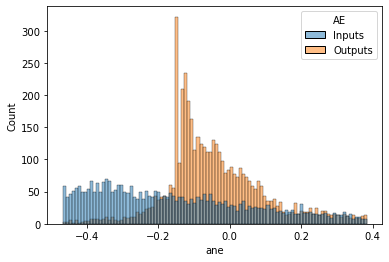

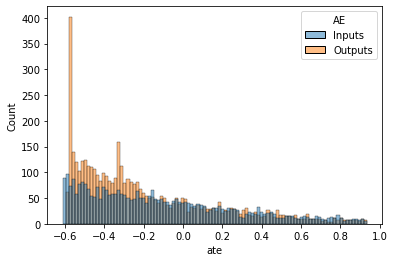

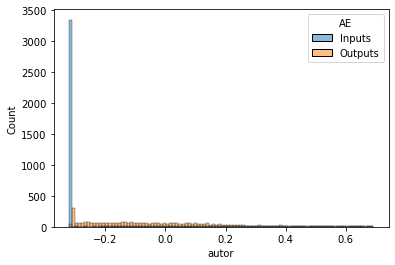

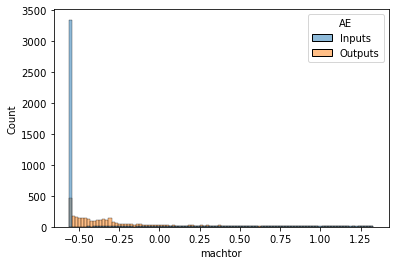

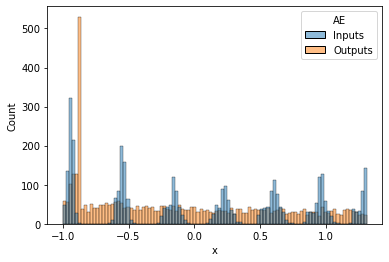

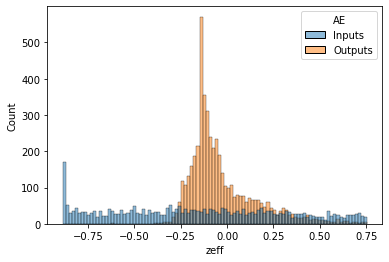

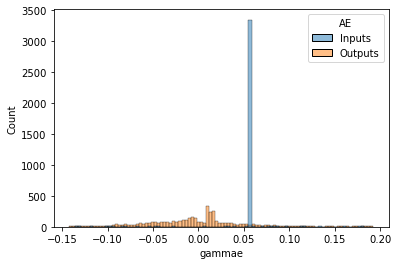

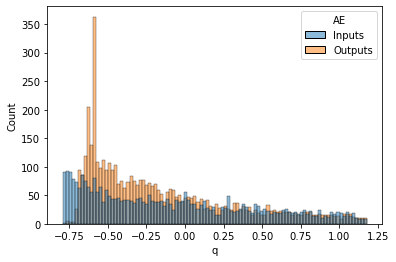

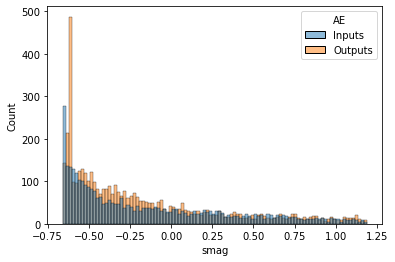

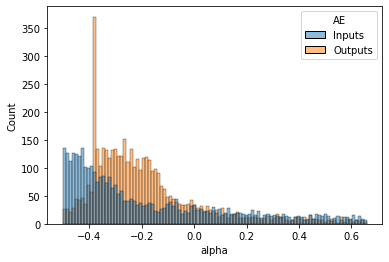

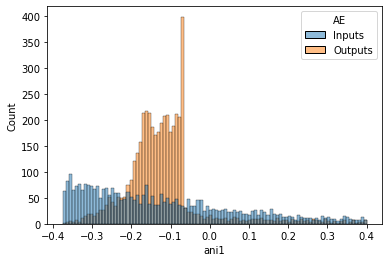

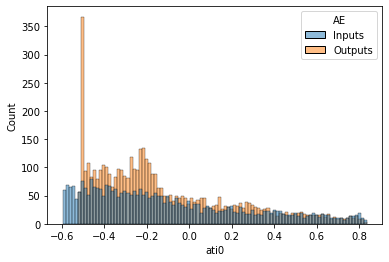

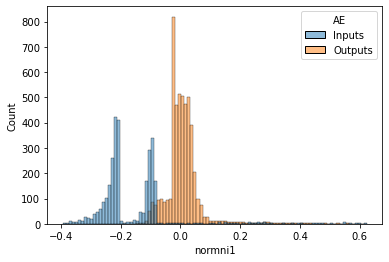

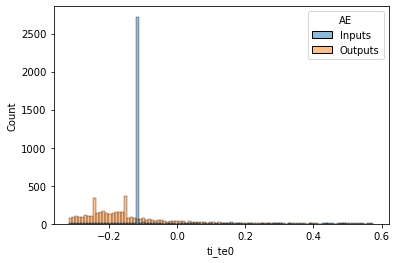

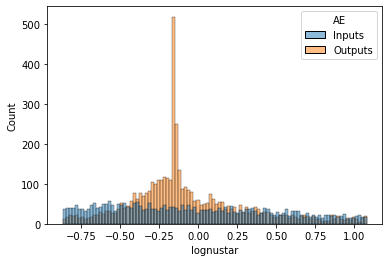

In [23]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample2[i].quantile(0.1)
    x_max = df_compare_sample2[i].quantile(0.9)
    sns.histplot(data = df_compare_sample2, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)